<a href="https://colab.research.google.com/github/824024445/Machine-learning-notes/blob/master/4%E8%AE%AD%E7%BB%83%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 本章内容
> 第一步  
将以一个简单的线性回归模型为例，讨论两种不同的训练方法来得到模型的最优解
- 1.直接在封闭方程上求根
- 2.迭代，梯度下降（GD）的方法  

> 第二步  
研究更复杂的模型:多项式回归，**可以拟合非线性数据集**。由于参数多，多以容易出现过拟合，所以本章**还会介绍如何判断是否过拟合**，并介绍几种正则化方法减少过拟合。

> 第三步  
介绍两种常用的分类模型：Logistic回归和Softmax回归

# 一、线性回归模型为例
> 写在前面，不管是以封闭方程求解，还是通过梯度下降求解。都只是求解的方式而已。不全部封闭方程求解只是为了节省资源加快速度。  
LinearRegression预测器使用封闭求解。SCDRegressor预测器使用梯度下降求解。

## 1.1 在封闭方程上求根


### 1.1.1 自己实现

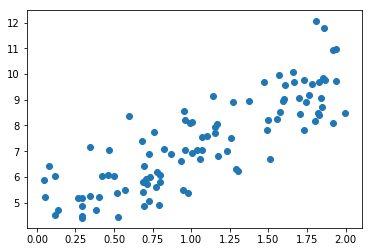

In [0]:
import numpy as np
import matplotlib.pyplot as plt

X = 2*np.random.rand(100, 1) # rand是生成平均分布的浮点数
y = 4 + 3*X + np.random.randn(100, 1) # randn是生成正态分布的浮点数

plt.scatter(X, y)
plt.show()


> f(x) = w1x1 + w2x2 + w3x3 + ... + wdxd + b  
向量w* = (w1, w2, w3, ... , wd, b)   
线性模型就是求均方差最小的那条线的w*  
省略西瓜书上的推导过程，结果为：w* = (X<sup>T</sup>X)<sup>-1</sup>X<sup>T</sup>y  
通过Numpy 的线性代数模块（`np.linalg`）中的`inv()`函数来计算矩阵的逆，以及`dot()`方法来计算矩阵的乘法。

In [0]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.50080561],
       [2.66101173]])

求得的参数，第一个是截距的，第二个是参数w。 取决于X的组成，如果1在第一列，那么截距就是第一个参数，如果1在最后一列，那么截距就是最后一个。

进行预测

In [0]:
X_new = np.array([[0], [2]])
# X_new_b = np.c_[X_new, np.ones((2, 1))]
X_new_b = np.c_[np.ones((2, 1)), X_new]

y_predict = X_new_b.dot(theta_best)
y_predict


array([[4.50080561],
       [9.82282906]])

画出图形

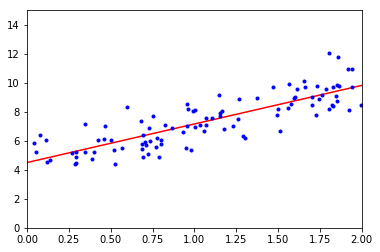

In [0]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0,2,0,15])
plt.show()

### 1.1.2使用sklearn实现相同效果

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(X, y)
y_predict_sk = lin_reg.predict(X_new)
print(lin_reg.intercept_, lin_reg.coef_)
y_predict_sk

[4.50080561] [[2.66101173]]


array([[4.50080561],
       [9.82282906]])

## 1.2 梯度下降
封闭求解的话，在内存足够时没有问题。在特征个数非常多，训练实例非常多，内存无法满足要求的时候，就可以使用梯度下降的方法了  
梯度下降的整体思路是通过的迭代来逐渐调整参数使得损失函数达到最小值  
> 损失函数对某一特征求偏导

### 1.2.1 批量梯度下降
对每一个w计算损失函数的梯度  
对于一个数千数量特征的线性回归模型，批量梯度下降要比使用封闭方程快的多

In [0]:
eta = 0.1 # 学习率
n_iterations = 1000 # 迭代次数
m = 100
theta = np.random.randn(2,1) # 随机初始值
for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients
  
theta

array([[4.50080561],
       [2.66101173]])

### 1.2.2 随机梯度下降
批量下降每一次迭代都要用到整个训练集  
随机梯度下降是：每次只对随机的一点求梯度，即随机选取一点，然后比较两者之间的梯度，顺坡往下。

### 1.2.3 小批量梯度下降
小批量梯度下降就是介于批量梯度下降和随机梯度下降之间的一种方法。它使用一个随机的小型实例集来计算梯度。

# 二、多项式回归
如果数据不是直线呢？  
多项式函数：形如f(x)=an·x^n+an-1·x^(n-1)+…+a2·x^2+a1·x+a0的函数，叫做多项式函数，它是由常数与自变量x经过有限次乘法与加法运算得到的。比如n=1时y=kx+b为一次函数，n=2时y=ax^2+bx+c为二次函数。

多项式回归仍旧可以使用线性模型来拟合。
线性模型的函数为：f(x) = w1x1 + w2x2 + w3x3 + ... + wdxd + b  
比如我们现在有一个二次方程要被拟合：f(x) = 3x<sup>2</sup> + 4x + 5  
对样本集进行加权，相当于把x2作为一个新的特征，在样本集中加入样本的平方这一项，方程变为：f = 3x1 + 4x2 + 5  
原本的样本集的第一行为（a），那么对于对样本进行加权后的样本集的第一行为（a，a<sup>2</sup> ）

## 2.1实现多项式回归线性预测

数据集的转换通过sklearn.preprocessing下的PolynomialFeatures转换器来进行。  
其生成一个新的特征矩阵，该特征矩阵由特征的所有多项式组合组成，其度数小于或等于指定的度数。例如，如果输入样本是二维的并且形式为[a，b]，则2次多项式特征是[1，a，b，a ^ 2，ab，b ^ 2]。 

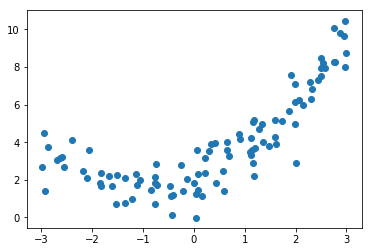

In [0]:
# 创建数据
import numpy as np
import matplotlib.pyplot as plt

m = 100
X = 6*np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.scatter(X, y)

In [0]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

print(X[0], X_poly[0])

[-2.93291658] [-2.93291658  8.60199965]


使用线性模型进行拟合

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_


(array([2.07476661]), array([[0.971435  , 0.50114459]]))

预测函数即为：F(x) = 0.54826828x2 + 1.02646781x + 1.8894
原始函数为：F(x) = 0.5x2 + x + 2 + 高斯噪声

## 2.2学习曲线
如果采用高阶多项式回归的话，拟合程度会更好。但是会非常用于出现过拟合。而如果只用线性模型的话又会欠拟合.  

在实际数据中，我们不知道到底应该用几阶的，所以就需要判断模型到底是欠拟合还是过拟合。当然，我们可以通过交叉验证每一阶来选取性能好的。  
  
 
但是本节讲的是另外一种方法，判断模型是否过欠拟合的方法：学习曲线就是以训练规模为自变量，性能表现为因变量的函数。 下面自己来写一个学习曲线的函数

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
    val_errors.append(mean_squared_error(y_val_predict, y_val))
  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
  plt.ylim([0, 3])
  plt.legend()

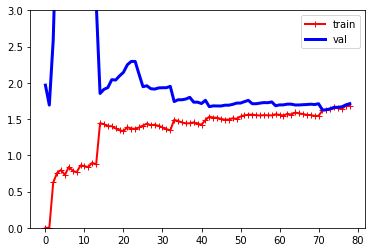

In [0]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

上面这个图典型的欠拟合。  
红线是训练集的均方误差，蓝色线是测试集的均方误差。数据很小时，训练集拟合的很好，所以误差小，但是泛化性能差，所以预测及的误差大。随着数据量的增大，最终误差在高位地带稳定，这是典型的欠拟合表现。说明数据之间的关系不是线性的。
> 也就是说，如果你的模型在训练集上是欠拟合的，那么添加再多的样本也是没有用的，应该换一个更好更复杂的模型。

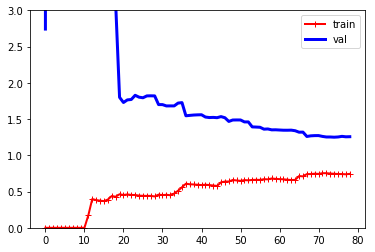

In [0]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline((
 ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
 ("sgd_reg", LinearRegression()),
))

plot_learning_curves(polynomial_regression, X, y)

过拟合的显著特点是：模型在训练集上的表现要比验证集上好得多。  
没有过拟合：数据量增大到训练误差和验证误差相等。

## 2.3线性模型的正则化
> 关于岭回归和lasso回归可以参考这篇文章https://www.cnblogs.com/Belter/p/8536939.html

改善过拟合的好方法就是正则化这个模型，即限制它，模型有越少的自由度，就越难出现过拟合。  
目标函数后面添加一个系数的“惩罚项”是正则化的常用方式，为了防止系数过大从而让模型变得复杂。  
对于一个线性模型，实现正则化就是约束模型中参数的权重，下面介绍三种方法  
- Ridge回归（岭回归）
- Lasso回归
- Elastic Net（弹性网络）


### 2.3.1 Ridge（岭）回归
也成Tikhonov正则化，就是线性回归的正则化版。
它跟线性回归的区别就在于：损失函数不一样，加上所有参数（不包括θ0）的平方和，即l2范数，此时叫做岭回归  
加上所有参数（不包括θ0）的绝对值之和，即l1范数，此时叫做Lasso回归；   
θ0是截距  
> 其实正则就是为了压缩嘛，拿y=kx+b模型来说，如果模型的参数k太大，那么损失函数也会比较抖。参数越大，损失函数的正则化项就越大

In [0]:
# 使用封闭方程求解
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)

ridge_reg.predict([[1.5]])

array([[5.17319563]])

In [0]:
# 使用随机梯度法求解

from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l2") #penalty参数l2是指在损失函数上加上权重向量l2范数平方的一半
sgd_reg.fit(X, y.ravel())  # ravel将多维数组转变为一维数组
sgd_reg.predict([[1.5]])

array([5.15736621])

### 2.3.2 Lasso回归
另一种线性回归的正则化版本  
损失函数加上所有参数（不包括θ0）的绝对值之和，即l1范数，此时叫做Lasso回归；

In [0]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)

lasso_reg.predict([[1.5]])

array([5.1374329])

### 2.3.3弹性网络（ElasticNet）
介于岭回归和Lasso回归之间，损失函数加上L1范数和L2范数的混合，可以控制混合率，混合率r=0是，就是岭回归。

In [0]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.13637396])

### 2.3.4早期停止法（Ealy Stopping）
对于迭代学习方法，有一种非常特殊的正则化方法。一旦验证误差达到最小值，就提早停止训练，这种正则方法叫做早期停止法

# 三、分类中的Logistic回归和Softmax回归
以鸢尾花数据为例

## 3.1逻辑回归 



In [0]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(np.int)

In [0]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

log_reg.predict([[1.7], [1.5]])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([1, 0])

## 3.2 Softmax回归
Logistic 回归模型可以直接推广到支持多类别分类，不必组合和训练多个二分类器。  
也称作多类别 Logistic 回归

使用方法：将LogisticRregression的multi_class参数设置为“multinomial”来把它改变为 Softmax 回归。  
还必须指定一个支持 Softmax 回归的求解器，例如“lbfgs”求解器  
还默认使用L2正则化

In [0]:
X = iris["data"][:, (2, 3)] # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
softmax_reg.predict([[5, 2]])

array([2])

In [0]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])